Este notebook tem como objetivo realizar o treinamento dos dados por meio de técnicas de aprendizado não supervisionado, aplicando clusterização para identificar padrões relacionados ao crime de tráfico de drogas em diferentes bairros. Além disso, busca-se detectar quais bairros apresentam crescimento dessas ocorrências, possibilitando alertas mais precisos para ações preventivas

Importando bibliotecas.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

Lendo o arquivo

In [5]:
df = pd.read_csv("C:/Users/55819/Downloads/Previs-o_crimes-main (1)/Previs-o_crimes-main/data/processed/dados_processados.csv")
df.head(10)

,data_ocorrencia,bairro,tipo_crime,descricao_modus_operandi,arma_utilizada,quantidade_vitimas,quantidade_suspeitos,sexo_suspeito,idade_suspeito,orgao_responsavel,ano,mes,dia,hora,minuto,segundo,dia_semana_num,dia_semana_nome,estacao
0,2024-08-02 19:48:16.958668,Imbiribeira,Sequestro,Golpe Telefônico,Faca,2,0,Não Informado,53,Delegacia Casa Forte,2024,8,2,19,48,16,4,Friday,Inverno
1,2022-10-29 19:48:16.958694,Boa Viagem,Homicídio,Fraude Online,Objeto Contundente,4,1,Não Informado,29,Delegacia Casa Forte,2022,10,29,19,48,16,5,Saturday,Primavera
2,2023-03-12 19:48:16.958698,Santo Amaro,Furto,Invasão Residencial,Nenhum,1,4,Feminino,65,Delegacia Casa Forte,2023,3,12,19,48,16,6,Sunday,Outono
3,2025-04-18 19:48:16.958700,Afogados,Roubo,Arrombamento,Nenhum,1,4,Não Informado,30,Delegacia Torre,2025,4,18,19,48,16,4,Friday,Outono
4,2025-06-30 19:48:16.958702,Tamarineira,Roubo,Estupro Coletivo,Arma de Fogo,3,3,Masculino,20,Delegacia Casa Forte,2025,6,30,19,48,16,0,Monday,Inverno
5,2024-04-19 19:48:16.958705,Torre,Ameaça,Estupro Coletivo,Nenhum,0,1,Não Informado,32,Delegacia Pina,2024,4,19,19,48,16,4,Friday,Outono
6,2022-11-28 19:48:16.958708,Tamarineira,Homicídio,Estelionato Bancário,Explosivos,0,4,Feminino,28,Delegacia Boa Viagem,2022,11,28,19,48,16,0,Monday,Primavera
7,2024-11-10 19:48:16.958710,Boa Viagem,Sequestro,Estelionato Bancário,Explosivos,1,2,Não Informado,24,Delegacia Pina,2024,11,10,19,48,16,6,Sunday,Primavera
8,2025-01-13 19:48:16.958717,Tamarineira,Latrocínio,Golpe Telefônico,Faca,3,2,Não Informado,14,Delegacia Afogados,2025,1,13,19,48,16,0,Monday,Verão
9,2025-01-25 19:48:16.958720,Torre,Tráfico de Drogas,Emboscada,Explosivos,3,3,Feminino,23,Delegacia Boa Viagem,2025,1,25,19,48,16,5,Saturday,Verão


1 - filtrar um DataFrame para criar um novo DataFrame chamado df_trafico contendo apenas as linhas onde a coluna tipo_crime contém a palavra "tráfico"

In [6]:
df_trafico = df[df['tipo_crime'].str.contains('tráfico', case=False, na=False)].copy()

2 - criar uma nova coluna tem_arma no DataFrame df_trafico, que indica com 1 se há alguma informação sobre a arma utilizada (diferente de 'não informado'), e com 0 se a informação não foi fornecida.

In [7]:
df_trafico['tem_arma'] = np.where(df_trafico['arma_utilizada'].str.lower() != 'não informado', 1, 0)


3 - agrupar os dados de crimes de tráfico por bairro e calcula médias de variáveis como:

número de suspeitos,

número de vítimas,

idade dos suspeitos,

percentual de ocorrências com arma (proporção),

e horário médio dos crimes.

Depois, ele renomeia as colunas para nomes mais claros.

In [8]:
df_bairros = df_trafico.groupby('bairro').agg({
    'quantidade_suspeitos': 'mean',
    'quantidade_vitimas': 'mean',
    'tem_arma': 'mean',  # percentual de ocorrências com arma
    'idade_suspeito': 'mean',
    'hora': 'mean'       # horário médio das ocorrências
}).reset_index()

# Renomear colunas
df_bairros.rename(columns={
    'quantidade_suspeitos': 'media_suspeitos',
    'quantidade_vitimas': 'media_vitimas',
    'tem_arma': 'percentual_com_arma',
    'idade_suspeito': 'media_idade_suspeitos',
    'hora': 'media_hora'
}, inplace=True)

4 - realizar tratamento de dados ausentes (NaN) e prepara os dados para padronização (normalização)

In [11]:
df_bairros.fillna(df_bairros.mean(numeric_only=True), inplace=True)

scaler = StandardScaler()
X = scaler.fit_transform(df_bairros.drop(columns='bairro'))

No código abaixo vou realizar clusterização usando o algoritmo KMeans com 4 clusters, atribuindo os clusters ao DataFrame df_bairros, e em seguida avalia a qualidade da clusterização usando três métricas de avaliação não supervisionadas: Silhouette Score, Davies-Bouldin Index e Calinski-Harabasz Index.

In [13]:
kmeans = KMeans(n_clusters=4, random_state=42)
df_bairros['cluster'] = kmeans.fit_predict(X)

# Calcular métricas de avaliação usando X (que já está padronizado)
silhouette = silhouette_score(X, df_bairros['cluster'])
davies_bouldin = davies_bouldin_score(X, df_bairros['cluster'])
calinski = calinski_harabasz_score(X, df_bairros['cluster'])

print(f"Silhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")
print(f"Calinski-Harabasz Index: {calinski:.3f}")

Silhouette Score: 0.397
Davies-Bouldin Index: 0.567
Calinski-Harabasz Index: 7.084


5 - calcular e exiber a média dos dados numéricos para cada cluster criados, agrupando os bairros de acordo com o cluster ao qual pertencem.

In [14]:
cluster_summary = df_bairros.groupby('cluster').mean(numeric_only=True).round(2)
print("MÉDIAS DOS CLUSTERS:")
print(cluster_summary)

MÉDIAS DOS CLUSTERS:
         media_suspeitos  media_vitimas  percentual_com_arma  \
cluster                                                        
0                   1.78           1.61                  1.0   
1                   1.78           2.06                  1.0   
2                   2.22           2.14                  1.0   
3                   2.13           1.81                  1.0   

         media_idade_suspeitos  media_hora  
cluster                                     
0                        41.17        19.0  
1                        43.05        19.0  
2                        42.05        19.0  
3                        39.53        19.0  


6 - Gerar um resumo descritivo e interpretativo automático para cada cluster, baseado nas médias calculadas das variáveis de interesse em cada grupo de bairros, e imprime esse resumo no console.

In [15]:
print("\nRESUMO AUTOMÁTICO DOS CLUSTERS:\n")

for c in sorted(df_bairros['cluster'].unique()):
    grupo = df_bairros[df_bairros['cluster'] == c]
    qtd_bairros = grupo.shape[0]
    media_suspeitos = grupo['media_suspeitos'].mean().round(2)
    perc_arma = (grupo['percentual_com_arma'].mean() * 100).round(1)
    hora_media = grupo['media_hora'].mean().round(1)
    idade_media = grupo['media_idade_suspeitos'].mean().round(1)

    # gerar “interpretação automática”
    interpretacao = []
    if perc_arma > 40:
        interpretacao.append("tráfico armado")
    else:
        interpretacao.append("tráfico sem arma")

    if media_suspeitos >= 2:
        interpretacao.append("com vários suspeitos (organizado)")
    else:
        interpretacao.append("isolado (poucos suspeitos)")

    if hora_media >= 18:
        interpretacao.append("ocorrendo mais à noite")
    elif hora_media <= 6:
        interpretacao.append("ocorrendo de madrugada")
    else:
        interpretacao.append("ocorrendo durante o dia")

    print(f"Cluster {c} ({qtd_bairros} bairros):")
    print(f"Média de suspeitos: {media_suspeitos}")
    print(f"{perc_arma}% dos casos com arma")
    print(f"Idade média dos suspeitos: {idade_media} anos")
    print(f"Horário médio das ocorrências: {hora_media}h")
    print(f"Perfil: {', '.join(interpretacao)}")
    print(f"Bairros: {', '.join(grupo['bairro'].to_list())}")
    print("-" * 80)


RESUMO AUTOMÁTICO DOS CLUSTERS:

Cluster 0 (1 bairros):
Média de suspeitos: 1.78
100.0% dos casos com arma
Idade média dos suspeitos: 41.2 anos
Horário médio das ocorrências: 19.0h
Perfil: tráfico armado, isolado (poucos suspeitos), ocorrendo mais à noite
Bairros: Espinheiro
--------------------------------------------------------------------------------
Cluster 1 (5 bairros):
Média de suspeitos: 1.78
100.0% dos casos com arma
Idade média dos suspeitos: 43.1 anos
Horário médio das ocorrências: 19.0h
Perfil: tráfico armado, isolado (poucos suspeitos), ocorrendo mais à noite
Bairros: Afogados, Casa Forte, Graças, Pina, Torre
--------------------------------------------------------------------------------
Cluster 2 (2 bairros):
Média de suspeitos: 2.22
100.0% dos casos com arma
Idade média dos suspeitos: 42.0 anos
Horário médio das ocorrências: 19.0h
Perfil: tráfico armado, com vários suspeitos (organizado), ocorrendo mais à noite
Bairros: Boa Viagem, Tamarineira
------------------------

7- Por fim, Visualizar, em 2D, os agrupamentos (clusters) dos bairros baseados no perfil dos crimes de tráfico, facilitando a interpretação visual de como os clusters estão separados e quais bairros estão em cada grupo.

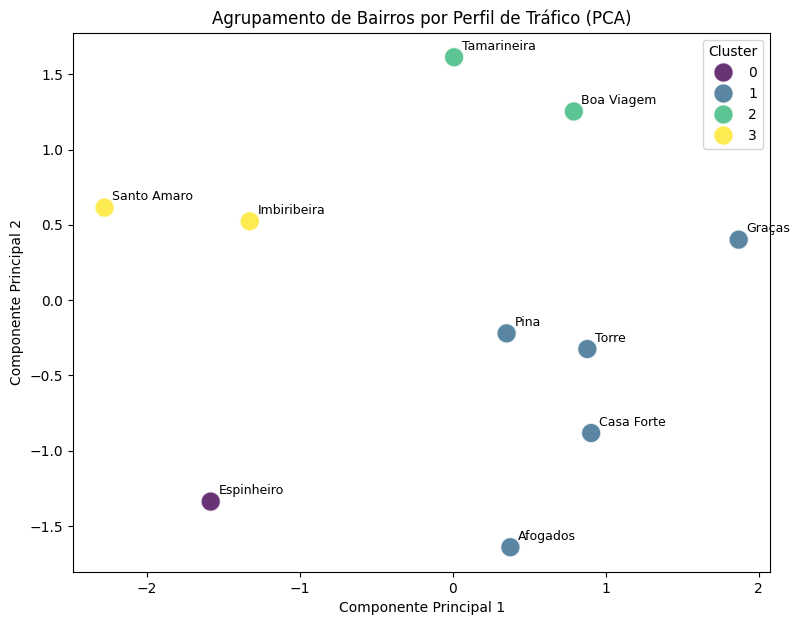

In [16]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Pegar apenas as features numéricas padronizadas
from sklearn.preprocessing import StandardScaler

features = ['media_suspeitos', 'media_vitimas', 'percentual_com_arma', 'media_idade_suspeitos', 'media_hora']
X = df_bairros[features]
X_scaled = StandardScaler().fit_transform(X)

# Reduzir para 2 dimensões
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Adicionar resultados ao dataframe
df_bairros['PCA1'] = pca_result[:, 0]
df_bairros['PCA2'] = pca_result[:, 1]

# Plotar os clusters agrupados
plt.figure(figsize=(9,7))
sns.scatterplot(
    data=df_bairros,
    x='PCA1',
    y='PCA2',
    hue='cluster',
    palette='viridis',
    s=200,
    alpha=0.8
)
for i, row in df_bairros.iterrows():
    plt.text(row['PCA1'] + 0.05, row['PCA2'] + 0.05, row['bairro'], fontsize=9)

plt.title('Agrupamento de Bairros por Perfil de Tráfico (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()
